# Installing the Dependencies

Use this code block to install the necessary tools

In [1]:
# !pip install -e .

# Loading the Dependencies

In [2]:
from deeplens.utils.analysis import *
from deeplens.pipeline import pipeline

# Initializing the Pipeline

In [3]:
original, original_output, modified_output = pipeline(
    text="He said he would",
    hf_model="gpt2",
    layer=3,
    sae_model=r"C:\code\deeplens\demo\model\gpt2_L3_1M.pt",
    sae_config=r"C:\code\deeplens\demo\model\config.yaml",
    feature=0,
    alpha=1000.0,
    tok_position=-1,
    generate=False,
    temperature=1.0
)

Running on device: cuda
Running on device: cuda
Running on device: cuda


In [4]:
analysis = AnalysisUtils(
    hf_model="gpt2",
    sae_model=r"C:\code\deeplens\demo\model\gpt2_L3_1M.pt",
    sae_config=r"C:\code\deeplens\demo\model\config.yaml",
    layer=3
)

# Plotting the Probability Distributions Over the Vocabulary

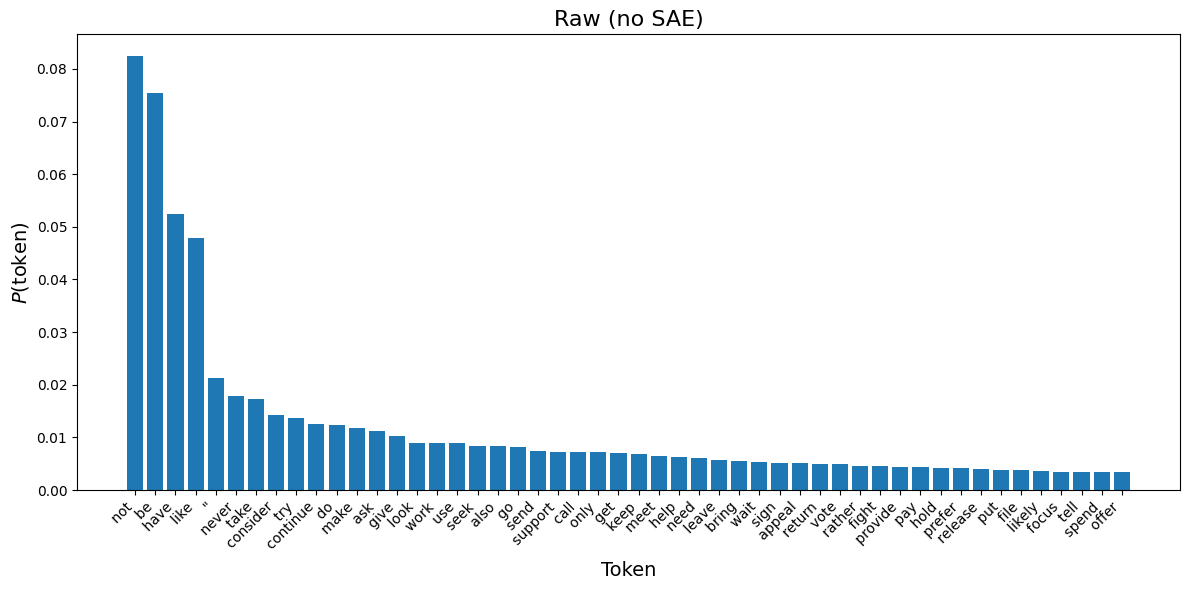

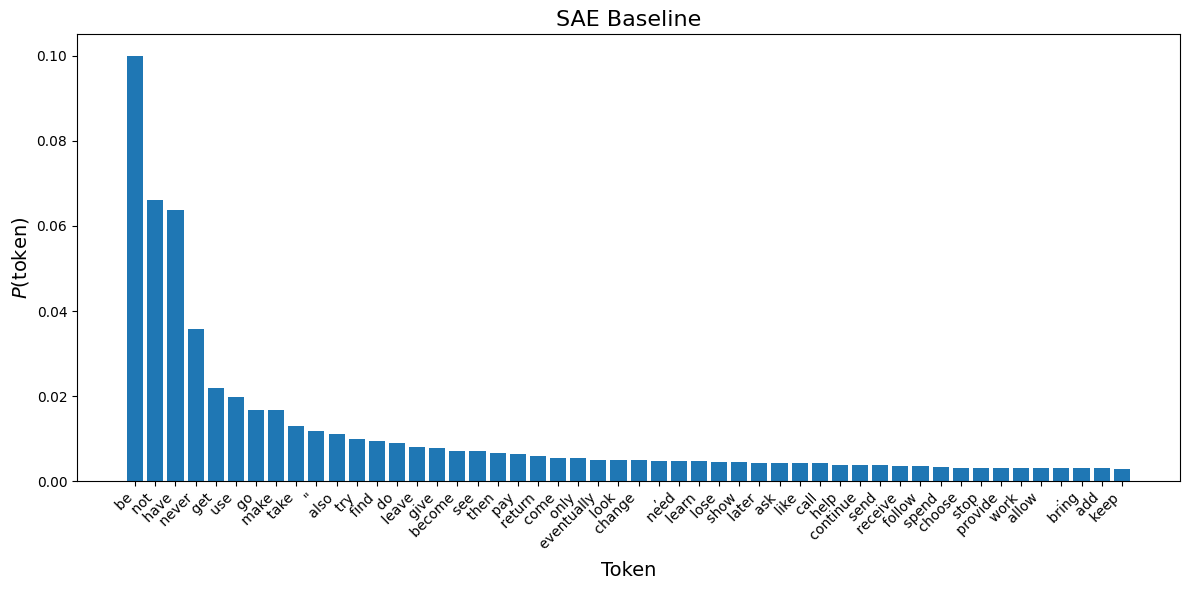

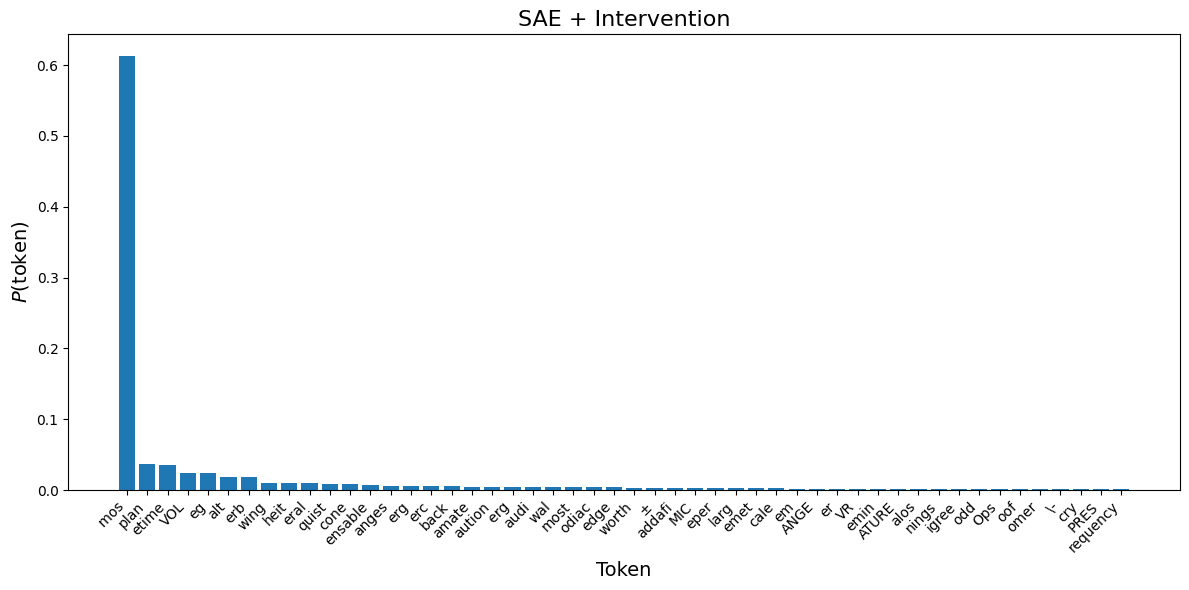

In [5]:
results = [original, original_output, modified_output]
titles = ["Raw (no SAE)", "SAE Baseline", "SAE + Intervention"]
for logits, title in zip(results, titles):
    analysis.plot_topk_distribution(
        logits=logits, 
        use_softmax=True, 
        k=50, 
        position=-1, 
        title=title
    )

# Plotting Logit Heatmaps

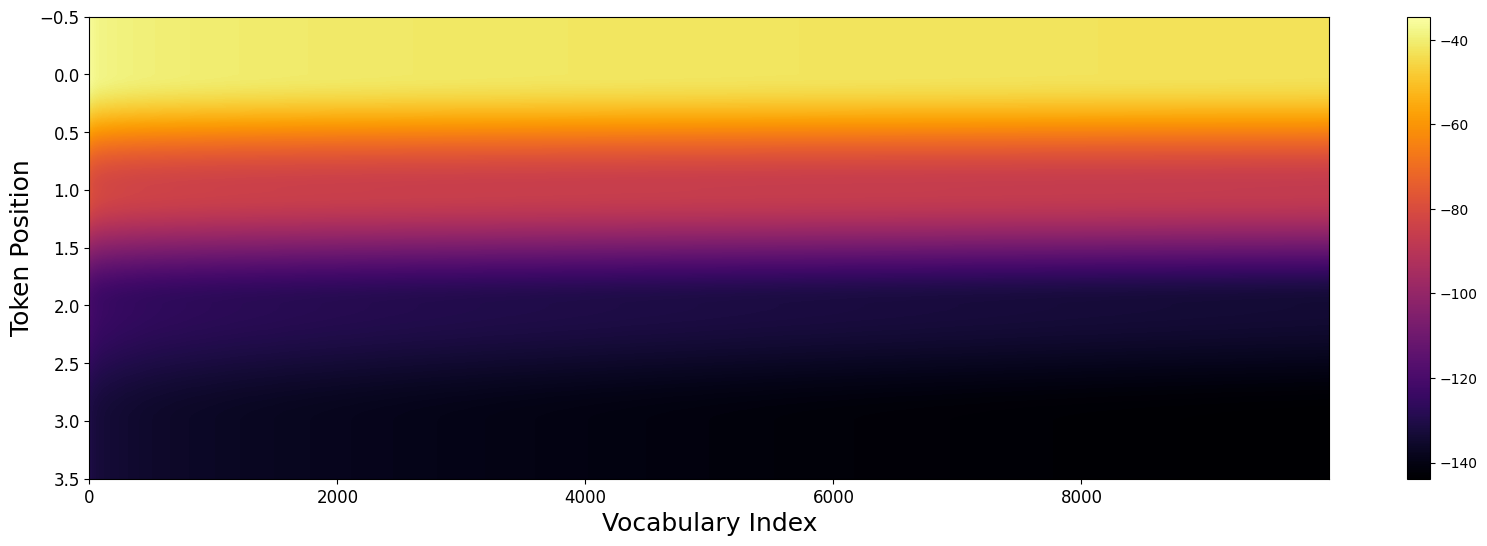

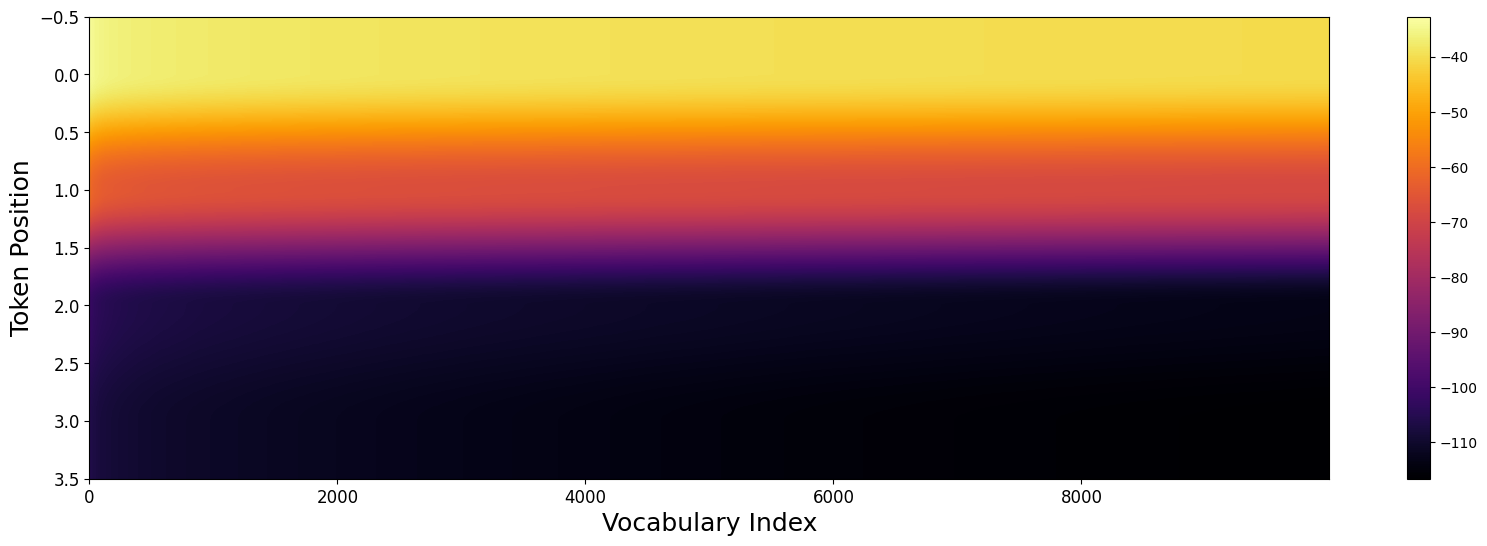

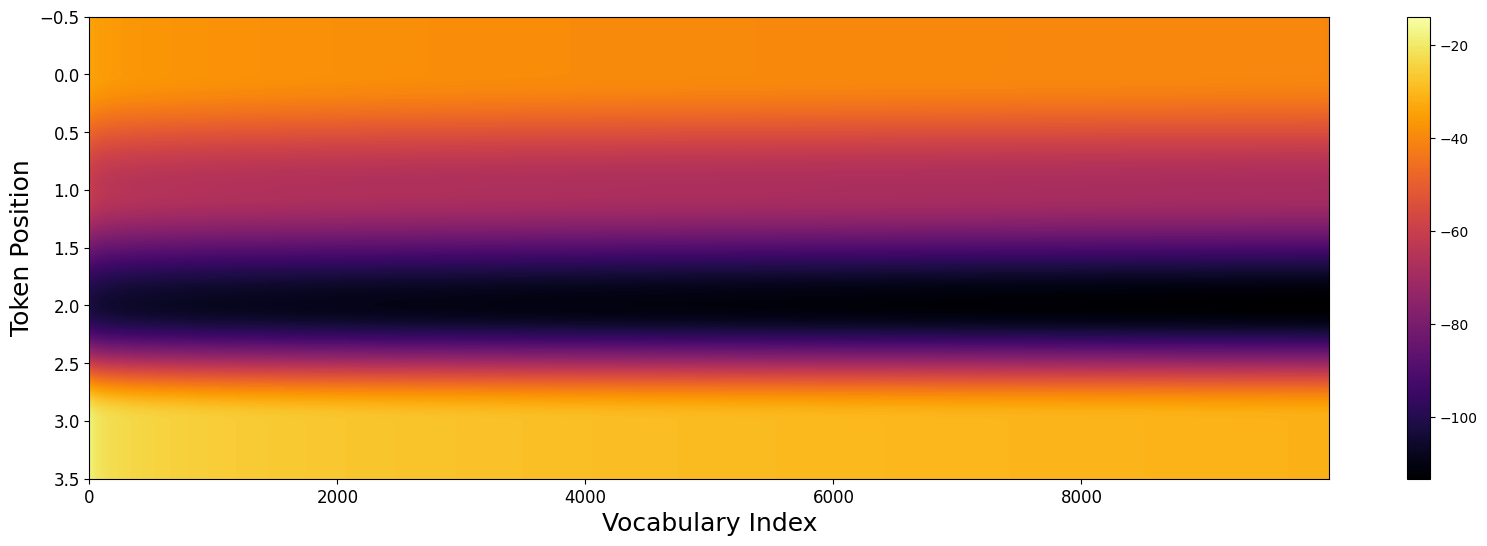

In [6]:
for logits in results:
    analysis.generate_logit_heatmap(
        logits=logits,
        k=10000
    )

# Get Top-k Predicted Tokens (per position)

In [7]:
results = analysis.get_top_k_tokens(
    logits=modified_output,
    k=5,
    to_dataframe=True,
    verbose=False
)
results

,position,rank,token,probability
0,0,1,.,4.362728e-09
1,0,2,",",4.176449e-09
2,0,3,of,3.674907e-09
3,0,4,-,3.448386e-09
4,0,5,\n,3.437419e-09
5,1,1,that,8.553824e-20
6,1,2,.,8.060288e-20
7,1,3,:,7.382161e-20
8,1,4,the,6.846787e-20
9,1,5,",",5.942513e-20


# Top-k Activated Features (across sentences; for specific tokens)

In [8]:
sentences = [
    # Wh-words in question context
    "What did you say to him?",
    "Where are you going tonight?",
    "When will the meeting start?",
    "Why did she leave so early?",
    "Who is coming to the party?",
    "Which color do you prefer?",
    # Wh-words in non-question context
    "What you did was unacceptable.",
    "Where he went remains a mystery.",
    "When she arrived surprised everyone.",
    "Why he left is still unclear.",
    "Who wins the game gets a prize.",
    "Which team plays first matters a lot.",
]

feats = analysis.get_most_active_features(
    sentences=sentences, 
    target=0,
    k=5,
    case_sensitive=False,
    return_values=True
)

Running on device: cuda
Running on device: cuda


In [9]:
for key, result in feats.items():
    print(key)
    print(f"\t{result.features}")
    if result.values is not None:
        print(f"\t{result.values}")

sent_1_pos_0_tok_What
	tensor([16227, 23665, 16751,    32, 18845])
	tensor([28.7891, 21.6041, 10.5138, 10.3676, 10.3348])
sent_2_pos_0_tok_Where
	tensor([16227, 23665, 16751,    32, 18845])
	tensor([28.6889, 21.7215, 10.5189, 10.4969, 10.3163])
sent_3_pos_0_tok_When
	tensor([16227, 23665, 16751, 18845,    32])
	tensor([28.9705, 21.2232, 10.6970, 10.4847,  9.9844])
sent_4_pos_0_tok_Why
	tensor([16227, 23665, 16751, 18845,    32])
	tensor([28.8302, 21.5570, 10.5717, 10.3757, 10.3139])
sent_5_pos_0_tok_Who
	tensor([16227, 23665,  9858,    32, 16751])
	tensor([28.4310, 22.2783, 11.2002, 10.9778, 10.3078])
sent_6_pos_0_tok_Which
	tensor([16227, 23665,  9858,    32, 16751])
	tensor([28.3191, 22.2715, 11.4459, 11.0902, 10.2036])
sent_7_pos_0_tok_What
	tensor([16227, 23665, 16751,    32, 18845])
	tensor([28.7891, 21.6041, 10.5138, 10.3676, 10.3348])
sent_8_pos_0_tok_Where
	tensor([16227, 23665, 16751,    32, 18845])
	tensor([28.6889, 21.7215, 10.5189, 10.4969, 10.3163])
sent_9_pos_0_tok_When
	